In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torchvision as tv

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device


device(type='cuda')

In [2]:
vgg = tv.models.vgg19(pretrained=True).features
vgg.eval()
vgg.requires_grad_(False)
vgg.training


C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


False

In [32]:
file_name = "init_with_content_1e-5"

imsize = 720
lr = 1e-3
epoch = 10000

w_c, w_s = 1, 100000
content_layers = ["conv4_2"]
style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1"]

# Don't ask me. *shrug* (VGG19 & Imagenet
norm_mean = torch.tensor([0.485, 0.456, 0.406])
norm_std = torch.tensor([0.229, 0.224, 0.225])


In [4]:
class ContentLoss(nn.Module):
    def __init__(self, t):
        super(ContentLoss, self).__init__()
        self.t = t.detach()
        self.loss = None

    def forward(self, inp):
        self.loss = func.mse_loss(inp, self.t)
        return inp


In [5]:
def gram_m(inp):
    bs, fm, h, w = inp.size()
    feats = inp.view(bs * fm, h * w)

    return torch.mm(feats, feats.T).div(bs * fm * h * w)

class StyleLoss(nn.Module):
    def __init__(self, t):
        super(StyleLoss, self).__init__()
        t = t.detach()
        self.t = gram_m(t)
        self.loss = None

    def forward(self, inp):
        self.loss = func.mse_loss(gram_m(inp), self.t)
        return inp


In [6]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


In [33]:
def get_model_and_losses(cnn, content_inp, style_inp):
    c_losses, s_losses = [], []

    model = nn.Sequential()

    model.add_module("norm", Normalization(norm_mean, norm_std))

    i, j= 1, 1
    for n, l in cnn.named_children():
        if isinstance(l, nn.Conv2d):
            j += 1
            n = f"conv{i}_{j}"
        elif isinstance(l, nn.ReLU):
            l = nn.ReLU(inplace=False)
        elif isinstance(l, nn.MaxPool2d):
            i += 1
            j = 0
            l = nn.AvgPool2d(kernel_size=l.kernel_size,
                             stride=l.stride,
                             padding=l.padding,)
            n = f"pool{i}"
        else:
            raise RuntimeError()

        model.add_module(n, l)

        if n in content_layers:
            t = model(content_inp).detach()
            c_loss = ContentLoss(t)
            model.add_module(f"c_loss{i}_{j}", c_loss)
            c_losses.append(c_loss)

        if n in style_layers:
            t = model(style_inp).detach()
            s_loss = StyleLoss(t)
            model.add_module(f"s_loss{i}_{j}", s_loss)
            s_losses.append(s_loss)

    return model, c_losses, s_losses


In [34]:
loader = tv.transforms.Compose([
            tv.transforms.Resize([imsize, imsize]),
            tv.transforms.ToTensor()
            ])
trans = tv.transforms.ToPILImage()

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


def preview(img_tensor):
    trans(img_tensor.detach().to('cpu').squeeze(0)).show()

style_img = image_loader("./style.jpg")
content_img = image_loader("./content.jpg")
input_img = content_img.clone()
# input_img = torch.randn(content_img.size())

print(style_img.shape, content_img.shape)

preview(style_img)
preview(content_img)
preview(input_img)



torch.Size([1, 3, 720, 720]) torch.Size([1, 3, 720, 720])


In [35]:
m, cl, sl = get_model_and_losses(vgg, content_img, style_img)
x, yc, ys = [], [], []

input_img.requires_grad_(True)
opt = optim.Adam([input_img], lr=lr)

for i in range(epoch):
    with torch.no_grad():
        input_img.clamp_(0, 1)

    # if not (i + 1) % 100:
    #     preview(input_img)

    features = m(input_img)

    opt.zero_grad()
    content_loss, style_loss = 0, 0
    for l in cl:
        content_loss += l.loss
    for l in sl:
        style_loss += l.loss

    total_loss = w_c * content_loss + w_s * style_loss
    x.append(i)
    yc.append(w_c * content_loss.item())
    ys.append(w_s * style_loss.item())
    print(f"epoch {i}, total loss: {total_loss.item():.4f} | content loss: {content_loss * w_c:.4f} | style loss: {style_loss * w_s:.4f}")
    total_loss.backward()
    opt.step()

with torch.no_grad():
        input_img.clamp_(0, 1)



img = trans(input_img.squeeze(0))
img.save(f"./output/{file_name}.jpg")
with open("./output/log", 'a+') as f:
    f.write(f"{file_name}\n")
    f.write(f"imsize: {imsize}\n")
    f.write(f"lr: {lr}, epoch: {epoch}\n")
    f.write(f"w_c, w_s = {w_c}, {w_s}\n")
    f.write(f"style_layer: {', '.join(style_layers)}\n")
    f.write(f"content_layer: {', '.join(content_layers)}\n\n")

img.show()


epoch 0, total loss: 22.1253 | content loss: 0.0000 | style loss: 22.1253
epoch 1, total loss: 21.5259 | content loss: 0.0406 | style loss: 21.4853
epoch 2, total loss: 20.9635 | content loss: 0.1168 | style loss: 20.8468
epoch 3, total loss: 20.4121 | content loss: 0.2064 | style loss: 20.2057
epoch 4, total loss: 19.8677 | content loss: 0.2973 | style loss: 19.5703
epoch 5, total loss: 19.3302 | content loss: 0.3797 | style loss: 18.9505
epoch 6, total loss: 18.7991 | content loss: 0.4514 | style loss: 18.3477
epoch 7, total loss: 18.2759 | content loss: 0.5140 | style loss: 17.7619
epoch 8, total loss: 17.7615 | content loss: 0.5691 | style loss: 17.1924
epoch 9, total loss: 17.2571 | content loss: 0.6178 | style loss: 16.6393
epoch 10, total loss: 16.7630 | content loss: 0.6610 | style loss: 16.1020
epoch 11, total loss: 16.2805 | content loss: 0.6994 | style loss: 15.5811
epoch 12, total loss: 15.8110 | content loss: 0.7336 | style loss: 15.0774
epoch 13, total loss: 15.3559 | con

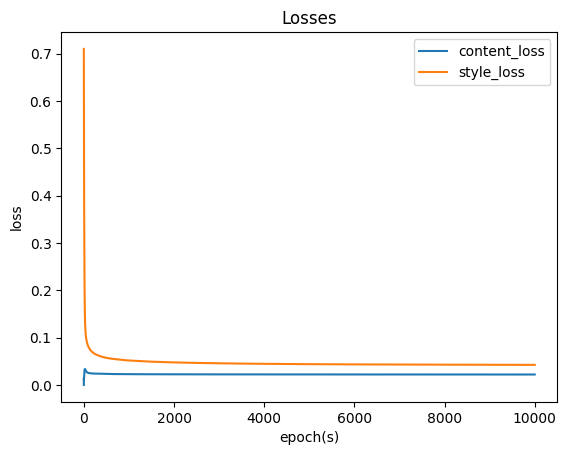

In [30]:
plt.plot(x, yc, label="content_loss")
plt.plot(x, ys, label="style_loss")

plt.xlabel('epoch(s)')
plt.ylabel('loss')
plt.title('Losses')

plt.legend()
plt.show()


## To-do
1. ori paper exp
2. avg pooling -> max pooling
3. test with multiple content layer
4. diff comb with content/ style layer